# **Stroke Prediction**

## ***Introduction***

Stroke remains one of the leading causes of death and long-term disability globally. Its sudden onset and severe consequences make it a critical public health concern. Early detection and risk assessment are essential for timely medical intervention, which can significantly reduce the likelihood of severe outcomes. Given the increasing availability of healthcare data, data-driven approaches to stroke prediction have the potential to revolutionize preventative care.

This project leverages the ([Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data)) from Kaggle, which includes health-related features such as age, gender, hypertension, heart disease, BMI, smoking status, and glucose levels. By employing machine learning techniques, the ***goal is to develop a predictive model that accurately classifies individuals at high risk of stroke***. Such a model can be a valuable tool for healthcare professionals, enabling timely interventions and potentially saving lives.

**Loaded the necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

**Loaded and prepared the dataset**

In [2]:
stroke_df = pd.read_csv('healthcare-dataset-stroke-data.csv')
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## ***Tidying the Dataset***

**Checked for missing (NaN) values** in the dataset to identify incomplete records.

In [3]:
missing_values = stroke_df.isnull().sum()
print(missing_values)

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


**Removed rows containing NaN values** to ensure data consistency and avoid errors during model training. **Verified the dataset again** to confirm that no missing values remained after cleaning.

In [4]:
stroke_df_cleaned = stroke_df.dropna()
display(stroke_df_cleaned.head())

print(stroke_df_cleaned.isnull().sum())

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


## ***Preliminary Analysis***

For the preliminary analysis, **Counted the number of cases for each class of the target variable (stroke)** to understand the distribution between stroke (1) and no-stroke (0) cases.

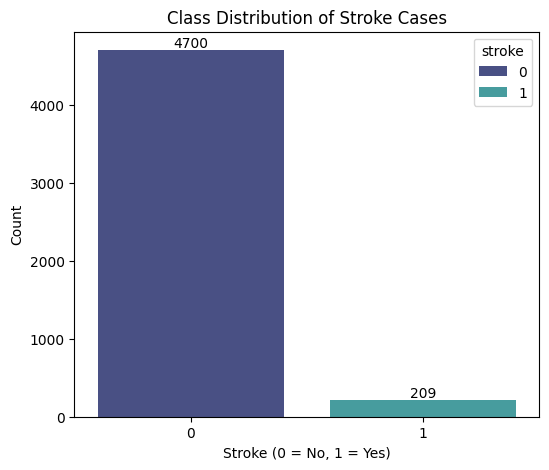

In [5]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x='stroke', data=stroke_df_cleaned, hue="stroke", palette='mako')
plt.title('Class Distribution of Stroke Cases')
plt.xlabel('Stroke (0 = No, 1 = Yes)')
plt.ylabel('Count')

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=10)

plt.show()


***Inference:*** The plot clearly shows a **severe class imbalance**, with **significantly more instances of class 0 (no stroke) than class 1 (stroke)**. This imbalance can lead the model to become biased toward the majority class, reducing its ability to accurately detect stroke cases.

**Visualizations were created to examine patterns in variables** such as age, BMI, average glucose level, and categorical factors like smoking status, work type, gender, and the presence of hypertension or heart disease. **The plots were used to highlight the potential impact of these features on stroke prediction**. This helped in identifying influential factors and guided the selection and engineering of features for the predictive model.

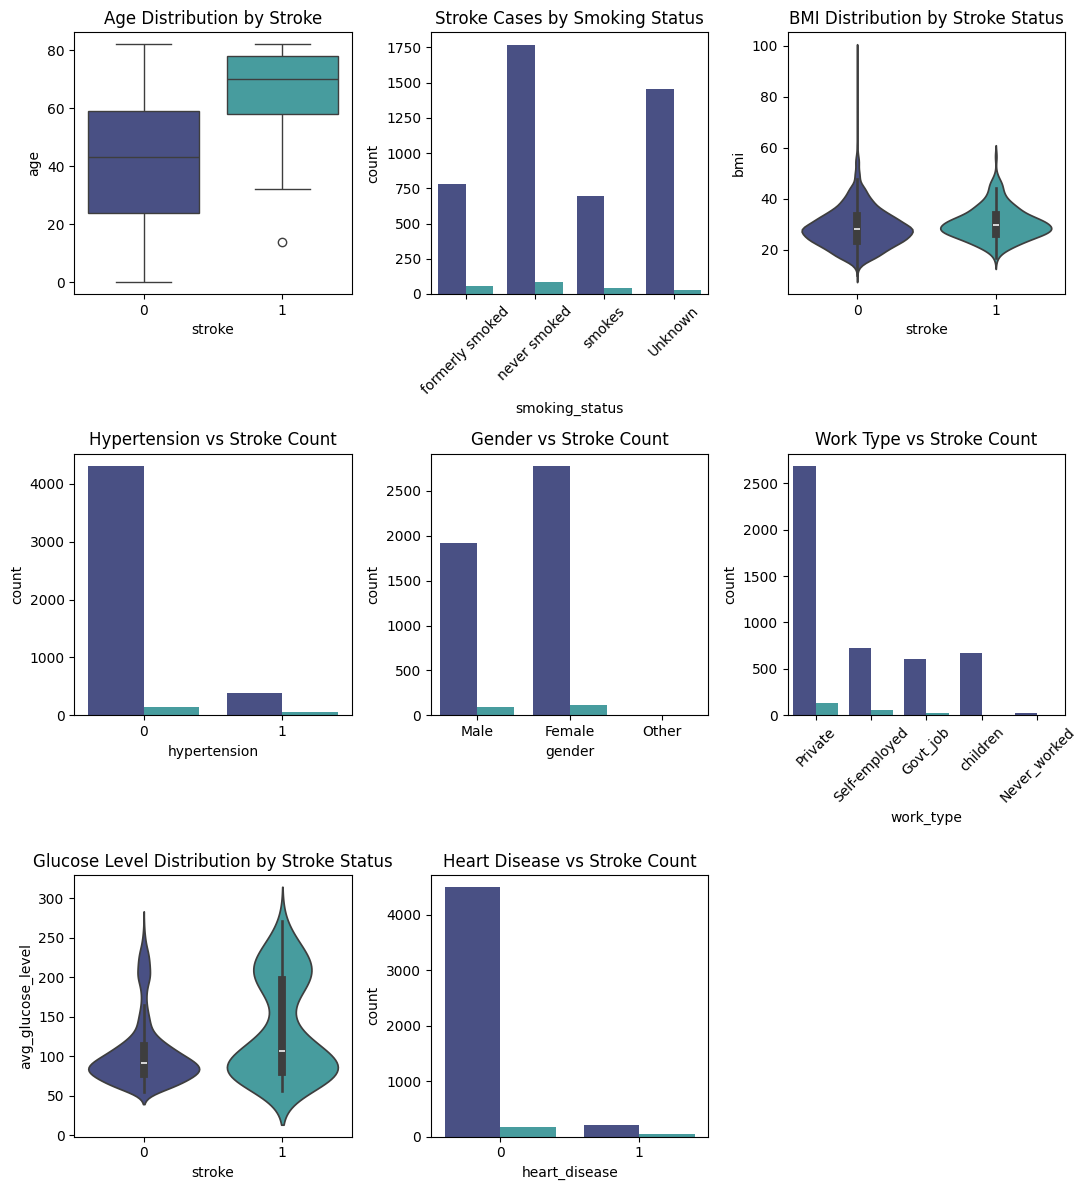

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(11, 12))

sns.boxplot(x="stroke", y="age", data=stroke_df_cleaned, hue="stroke", palette="mako", legend=False, ax=axes[0, 0])
axes[0, 0].set_title("Age Distribution by Stroke")

sns.countplot(x="smoking_status", data=stroke_df_cleaned,hue="stroke", palette="mako", legend=False, ax=axes[0, 1])
axes[0, 1].set_title("Stroke Cases by Smoking Status")
axes[0, 1].tick_params(axis='x', rotation=45)

sns.violinplot(x="stroke", y="bmi", data=stroke_df_cleaned, hue="stroke", palette="mako", legend=False, ax=axes[0, 2])
axes[0, 2].set_title("BMI Distribution by Stroke Status")

sns.countplot(x='hypertension', hue='stroke', data=stroke_df_cleaned, palette="mako", legend=False, ax=axes[1, 0])
axes[1, 0].set_title("Hypertension vs Stroke Count")

sns.countplot(x='gender', hue='stroke', data=stroke_df_cleaned, palette="mako", legend=False, ax=axes[1, 1])
axes[1, 1].set_title("Gender vs Stroke Count")

sns.countplot(x='work_type', hue='stroke', data=stroke_df_cleaned, palette="mako", legend=False, ax=axes[1, 2])
axes[1, 2].set_title("Work Type vs Stroke Count")
axes[1, 2].tick_params(axis='x', rotation=45)

sns.violinplot(x="stroke", y="avg_glucose_level", data=stroke_df_cleaned, hue="stroke", palette="mako", legend=False, ax=axes[2, 0])
axes[2, 0].set_title("Glucose Level Distribution by Stroke Status")

sns.countplot(x='heart_disease', hue='stroke', data=stroke_df_cleaned, palette="mako", legend=False, ax=axes[2, 1])
axes[2, 1].set_title("Heart Disease vs Stroke Count")

fig.delaxes(axes[2, 2])
plt.tight_layout()
plt.show()


## ***Preprocessing steps***

- **Separated the dataset into features (X) and target variable (y)**, where **y represents the stroke occurrence**.
- Split the data into **training and test sets** to evaluate model performance on unseen data, typically using an **80-20 ratio**.
- **Performed one-hot encoding on categorical features** to convert them into numerical format suitable for machine learning algorithms. It was applied after splitting the dataset to prevent data leakage — ensuring that information from the test set does not influence the encoding process or the training phase.

In [7]:
features = ['hypertension', 'work_type', 'Residence_type', 'heart_disease',
            'smoking_status', 'gender', 'age', 'bmi', 'ever_married', 'avg_glucose_level']
categorical_features = ['gender', 'work_type', 'Residence_type', 'ever_married', 'smoking_status']

#split
X = stroke_df_cleaned[features]
y = stroke_df_cleaned['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#one-hot encoding
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()

X_train_enc_df = pd.DataFrame(X_train_enc, columns=feature_names, index=X_train.index)
X_test_enc_df = pd.DataFrame(X_test_enc, columns=feature_names, index=X_test.index)

print("Training data:")
display(X_train_enc_df.head())

print("Testing data:")
display(X_test_enc_df.head())

Training data:


,onehot__gender_Female,onehot__gender_Male,onehot__gender_Other,onehot__work_type_Govt_job,onehot__work_type_Never_worked,onehot__work_type_Private,onehot__work_type_Self-employed,onehot__work_type_children,onehot__Residence_type_Rural,onehot__Residence_type_Urban,...,onehot__ever_married_Yes,onehot__smoking_status_Unknown,onehot__smoking_status_formerly smoked,onehot__smoking_status_never smoked,onehot__smoking_status_smokes,remainder__hypertension,remainder__heart_disease,remainder__age,remainder__bmi,remainder__avg_glucose_level
1473,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,49.0,40.2,139.43
4539,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,26.4,203.87
953,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,18.9,92.98
2563,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,57.0,26.5,90.40
2426,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,15.5,79.58


Testing data:


,onehot__gender_Female,onehot__gender_Male,onehot__gender_Other,onehot__work_type_Govt_job,onehot__work_type_Never_worked,onehot__work_type_Private,onehot__work_type_Self-employed,onehot__work_type_children,onehot__Residence_type_Rural,onehot__Residence_type_Urban,...,onehot__ever_married_Yes,onehot__smoking_status_Unknown,onehot__smoking_status_formerly smoked,onehot__smoking_status_never smoked,onehot__smoking_status_smokes,remainder__hypertension,remainder__heart_disease,remainder__age,remainder__bmi,remainder__avg_glucose_level
4020,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9.0,18.0,76.88
2170,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,77.0,19.4,80.85
2822,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,50.0,30.9,93.51
4759,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,46.0,29.5,59.74
1437,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,53.0,31.7,124.16


**Split the original training set further into training and validation sets using a 75-25 ratio** to fine-tune model parameters and monitor performance during training.
This allows for model evaluation on unseen data before final testing, helping to prevent overfitting and ensuring better generalization.

In [8]:
X_train_enc, X_val_enc, y_train, y_val = train_test_split(X_train_enc, y_train, test_size=0.25, random_state=42, stratify=y_train)

print(f"Training Set: {X_train_enc.shape}, {y_train.shape}")
print(f"Validation Set: {X_val_enc.shape}, {y_val.shape}")
print(f"Test Set: {X_test_enc.shape}, {y_test.shape}")

Training Set: (2945, 21), (2945,)
Validation Set: (982, 21), (982,)
Test Set: (982, 21), (982,)


**Scaled the feature data to normalize the range of all variables**, preventing features with larger numeric values from dominating the learning process.
This helps avoid unnecessary bias and ensures the model treats all features fairly during training.

In [9]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_enc)
X_val_scaled = scaler.transform(X_val_enc)
X_test_scaled = scaler.transform(X_test_enc)

## ***Models***

As we saw earlier, we had severe class imbalance, so **applied SMOTE (Synthetic Minority Over-sampling Technique) to balance the training data by generating synthetic examples for the minority class (stroke cases).**
This helps address the class imbalance and **improves the model's ability to learn patterns from underrepresented stroke cases**, leading to better recall and overall performance

In [10]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

***NOTE:*** We focus on **better recall** in this dataset because it measures how well the model identifies actual stroke cases (true positives). In healthcare, especially for life-threatening conditions like strokes, **missing a real case (false negative)** can have severe consequences. Prioritizing recall ensures that most individuals at risk are flagged for further medical evaluation, enabling **early intervention**—even if it means tolerating some false alarms.


### *Logistic Regression*

**Logistic Regression** is a supervised learning algorithm used for **binary classification**. It models the relationship between input features and the probability of a class using a sigmoid function, which outputs probabilities between 0 and 1. The model is trained to find the parameters that best separate the two classes.


**Fitted a Logistic Regression model on the resampled training data**. The model was trained with the resampled features (`X_train_resampled`) and target (`y_train_resampled`).
This helps ensure the model is not biased towards the majority class and can better predict stroke cases in imbalanced datasets.

In [11]:
# Fit logistic regression on resampled data
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_resampled, y_train_resampled)

print("Intercept:", logreg.intercept_)
print("Coefficients:", logreg.coef_)

Intercept: [-0.66076613]
Coefficients: [[-0.58104526 -0.71983799  0.         -0.72046945 -0.16502031 -0.57688598
  -0.69091746  0.43279378 -0.68104377 -0.59771367 -0.71415289 -0.62746773
  -0.65669272 -0.21498033 -0.44710087 -0.11418473  0.25107607  0.03264417
   2.26978814  0.08660422  0.1134527 ]]


**Predicted and evaluated performance** on the scaled validation set

In [12]:
# Predict on validation set
y_val_pred = logreg.predict(X_val_scaled)

# Evaluation metrics
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy: 0.7637474541751528

Confusion Matrix:
 [[715 225]
 [  7  35]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.76      0.86       940
           1       0.13      0.83      0.23        42

    accuracy                           0.76       982
   macro avg       0.56      0.80      0.55       982
weighted avg       0.95      0.76      0.83       982



***Inference:*** 
- The Logistic Regression model achieved a **validation accuracy of 76.4%**.
- The model demonstrated **strong performance** on the **majority class (`stroke = 0`)**.
- The **recall for stroke cases was high at 83%**, meaning the model correctly identified most individuals who actually had a stroke.
- While the **precision** for **`stroke = 1`** was lower at **12%**, indicating many predicted stroke cases were false positives.

### *K-Nearest Neighbour (KNN)*

**K-Nearest Neighbour (KNN)** is a simple, supervised learning algorithm used for classification. It predicts the class of a new data point by looking at the 'k' nearest neighbors in the training set and choosing the majority class. As a non-parametric, lazy learner, KNN doesn’t build a model beforehand but makes predictions based on the training data directly.

- **Performed 5-fold cross-validation on the training data** to identify the **optimal number of neighbors (k)** for the K-Nearest Neighbors (KNN) classifier, using F1 score as the evaluation metric due to class imbalance.
- **Used a pipeline combining SMOTE and KNN**, which ensures that the training data is resampled within each fold, preventing data leakage and allowing for more reliable model evaluation.

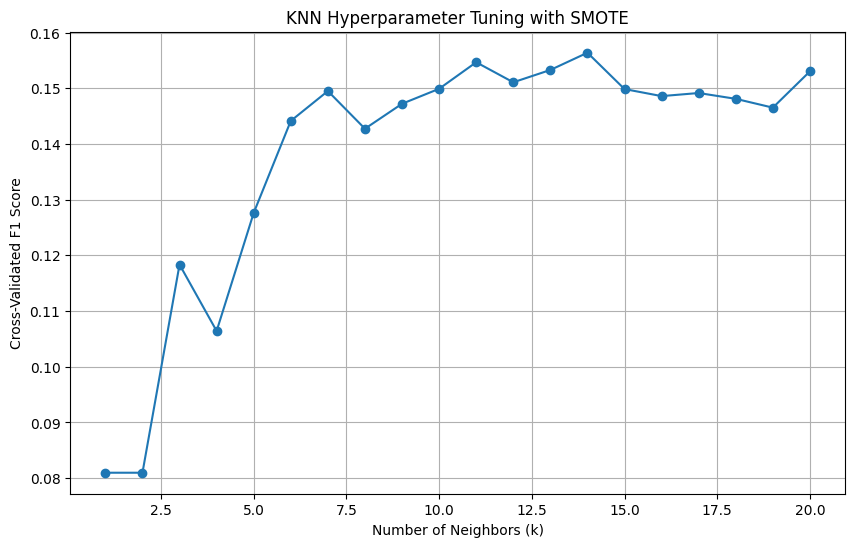

Best k: 14, with F1 score: 0.1564


In [13]:
k_range = range(1, 21)
cv_scores = []

for k in k_range:
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=k, weights='distance'))
    ])
    
    # Cross-validation (use scoring='f1' or 'f1_macro' if binary)
    scores = cross_val_score(pipeline, X_train_scaled, y_train, cv=5, scoring='f1')
    cv_scores.append(scores.mean())

# Plot the F1 scores
plt.figure(figsize=(10,6))
plt.plot(k_range, cv_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated F1 Score')
plt.title('KNN Hyperparameter Tuning with SMOTE')
plt.grid(True)
plt.show()

# Best k
best_k = k_range[np.argmax(cv_scores)]
print(f"Best k: {best_k}, with F1 score: {max(cv_scores):.4f}")


Limited the search to **20 values of k to avoid overfitting and reduce the risk of hyperparameter bias**. The value of ***k = 14*** with the ***highest average F1 score across folds, i.e. 0.1564*** was selected as the optimal choice.

- **Built the final KNN model** using the best value of k = 14 from cross-validation, within a pipeline that includes SMOTE to address class imbalance.
- **Fitted the model on the scaled training data**

In [14]:
best_k = 14

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=best_k, weights='distance'))
])

pipeline.fit(X_train_scaled, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=14, weights='distance'))])

**Predicted and evaluated performance** on the scaled validation set 

In [15]:
# Predict on the validation and test sets
y_val_pred = pipeline.predict(X_val_scaled)

# Evaluation metrics
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy: 0.8228105906313645

Confusion Matrix:
 [[788 152]
 [ 22  20]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.84      0.90       940
           1       0.12      0.48      0.19        42

    accuracy                           0.82       982
   macro avg       0.54      0.66      0.54       982
weighted avg       0.94      0.82      0.87       982



***Inference:*** 
* The KNN model achieved a **validation accuracy of 82.3%**.
*  The model demonstrated **strong performance** on the **majority class (`stroke = 0`)**.
*  **For the minority class (stroke = 1), the recall was 48%**, meaning the model correctly identified nearly half of the actual stroke cases.
*  While the **precision** for **`stroke = 1`** was lower at **12%**, indicating many predicted stroke cases were false positives.

### *Support Vector Machine (SVM)*

**Support Vector Machine (SVM)** is a supervised learning algorithm used for classification. It finds the optimal hyperplane that best separates the classes with the maximum margin. For non-linear data, SVM uses kernel functions (like RBF) to map data into higher dimensions where separation is possible. It performs well in high-dimensional spaces and is known for its accuracy and robustness.

- **Built a pipeline combining SMOTE and SVM** to address class imbalance and apply an SVM classifier with an RBF kernel.
- **Fitted the model on the  training data**.

In [16]:
svm_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42))
])

# Fit the model on the training data
svm_pipeline.fit(X_train_scaled, y_train) 

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('svm', SVC(random_state=42))])

**Predicted and evaluated performance** on the scaled validation set 

In [17]:
y_val_pred = svm_pipeline.predict(X_val_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Accuracy: 0.8207739307535642

Confusion Matrix:
 [[784 156]
 [ 20  22]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90       940
           1       0.12      0.52      0.20        42

    accuracy                           0.82       982
   macro avg       0.55      0.68      0.55       982
weighted avg       0.94      0.82      0.87       982



***Inference:*** 

* The **SVM model** achieved a **validation accuracy** of **76.4%**.
* The model demonstrated **strong performance** on the **majority class (`stroke = 0`)**.
* For the **minority class (`stroke = 1`)**, the **recall** was **83%**, meaning the model correctly identified a high proportion of actual stroke cases.
* The **precision** for **`stroke = 1`** was lower at **13%**, indicating many predicted stroke cases were false positives.

### *Voting Classifier*

**Voting** is an ensemble learning method that combines the predictions of multiple models to make a final decision. This approach leverages the strengths of different models, often improving overall performance.

- **Defined individual models**
    - Logistic Regression with balanced class weights
    - KNN with 14 neighbors and distance-based weighting
    - Support Vector Machine (SVM) with an RBF kernel and probability estimates enabled.
- Combined the three models into a Voting Classifier using **soft voting**, where the final prediction is based on the average of predicted probabilities from the models. Soft voting is used here to **leverage the strength of each model’s probability estimates, improving accuracy by reducing bias.**
- Built a **pipeline that first applies SMOTE to handle class imbalance** and then **fitted the Voting Classifier to the resampled and scaled training data.**

In [18]:
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
knn = KNeighborsClassifier(n_neighbors=14, weights='distance')
svm = SVC(kernel='rbf', probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('logreg', logreg), ('knn', knn), ('svm', svm)],
    voting='soft'
)

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('voting', voting_clf)
])

pipeline.fit(X_train_scaled, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('voting',
                 VotingClassifier(estimators=[('logreg',
                                               LogisticRegression(class_weight='balanced',
                                                                  max_iter=1000,
                                                                  random_state=42)),
                                              ('knn',
                                               KNeighborsClassifier(n_neighbors=14,
                                                                    weights='distance')),
                                              ('svm',
                                               SVC(probability=True,
                                                   random_state=42))],
                                  voting='soft'))])

- The model is used to **predict the target labels** for the scaled validation set (`X_val_scaled`).
- **Evaluated the model on the validation set**.

In [22]:
y_val_pred = pipeline.predict(X_val_scaled)

# Evaluate
print("Validation Performance:")
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC AUC:", roc_auc_score(y_val, pipeline.predict_proba(X_val_scaled)[:, 1]))

Validation Performance:

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91       940
           1       0.12      0.48      0.19        42

    accuracy                           0.83       982
   macro avg       0.55      0.66      0.55       982
weighted avg       0.94      0.83      0.88       982

Accuracy: 0.8309572301425662
ROC AUC: 0.817451874366768


***Inference:***
- The model achieved a **validation accuracy of 83.1%**, showing strong overall classification performance.
- For the **majority class (`stroke = 0`), precision (0.97) and recall (0.85) were high**, indicating the model correctly identified most non-stroke cases.
- For the **minority class (`stroke = 1`), recall was 48%**, meaning the model successfully identified nearly half of the actual stroke cases—an important metric in healthcare contexts where missing a case can be critical.
- **Precision for `stroke = 1` was low (12%)**, suggesting many false positives, but this trade-off is acceptable as higher recall is prioritized.
- The **ROC AUC score of 0.82** reflects good class separation and balanced performance across both classes.

## ***Conclusion***

Finally, in this project, we aimed to build a predictive model to detect stroke risk using medical and demographic features. We began with exploratory data analysis and preprocessing, addressed class imbalance using SMOTE, and evaluated individual models — Logistic Regression, KNN, and SVM — using pipelines and cross-validation.

Finally, we implemented a soft voting ensemble combining all three models, which performed consistently well. On the test set, the final model achieved:


In [23]:
y_test_pred = pipeline.predict(X_test_scaled)

print("Test Performance:")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC AUC:", roc_auc_score(y_test, pipeline.predict_proba(X_test_scaled)[:, 1]))

Test Performance:

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91       940
           1       0.13      0.48      0.20        42

    accuracy                           0.84       982
   macro avg       0.55      0.66      0.55       982
weighted avg       0.94      0.84      0.88       982

Accuracy: 0.8360488798370672
ROC AUC: 0.7749240121580547


***Inference***:
- **Accuracy: 83.6%**
- **Recall for stroke cases: 48%**
- **ROC AUC: 0.77**

These results indicate that the model generalizes well and is capable of identifying a reasonable proportion of stroke cases, making it a valuable tool for early risk flagging in healthcare.